# Brest Cancer Detection with PyTorch NN

## Imports

In [355]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics import (
    roc_curve,
    auc,
    confusion_matrix,
    precision_recall_fscore_support,
    precision_recall_curve,
    average_precision_score,
)

In [356]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)
np.random.seed(42)

## Data

In [357]:
data = load_breast_cancer()
X, y = data.data, data.target
feature_names = data.feature_names
target_names = data.target_names  # ['malignant', 'benign']

### Split and Scale Data

In [358]:
X_train_raw, X_test_raw, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_raw)
X_test_scaled = scaler.transform(X_test_raw)

# Keep enough components to explain 95% of variance
pca_preprocess = PCA(n_components=0.95, random_state=42)
X_train = pca_preprocess.fit_transform(X_train_scaled)
X_test = pca_preprocess.transform(X_test_scaled)

n_components = X_train.shape[1]
print(f"Reduced from 30 features to {n_components} components")
print(f"Explained variance: {pca_preprocess.explained_variance_ratio_.sum():.1%}")

Reduced from 30 features to 10 components
Explained variance: 95.1%


In [359]:
X_train

array([[ 4.24490333,  9.13142795,  1.5042624 , ...,  0.3287944 ,
        -3.73333374, -3.02100082],
       [ 9.05375518,  0.47530955, -3.1982151 , ..., -0.24366021,
         1.07048455,  1.27622399],
       [-2.27537401,  3.27847097,  2.81636955, ..., -0.48908126,
         0.49898538,  0.09575183],
       ...,
       [-4.50065362, -3.06780804, -0.0310455 , ...,  0.19623368,
         0.37833939,  0.31593534],
       [ 0.72828496,  0.42628657, -2.73093201, ..., -0.14224419,
         0.09370038, -0.52718302],
       [-3.40392527, -1.33038767, -0.14920956, ..., -0.58115308,
        -0.25740565,  0.0867945 ]], shape=(455, 10))

In [360]:
y_train

array([1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0,
       1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1,
       1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1,
       1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1,
       0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0,
       1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1,
       0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1,
       1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1,
       1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0,
       1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1,
       0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1,
       1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0,
       1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0,
       0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1,

### Convert to Tensors

In [361]:
X_train_tensor = torch.from_numpy(X_train).float()
X_test_tensor = torch.from_numpy(X_test).float()

y_train_tensor = torch.from_numpy(y_train).float().unsqueeze(1)
y_test_tensor = torch.from_numpy(y_test).float().unsqueeze(1)

### EDA

#### Class Distribution

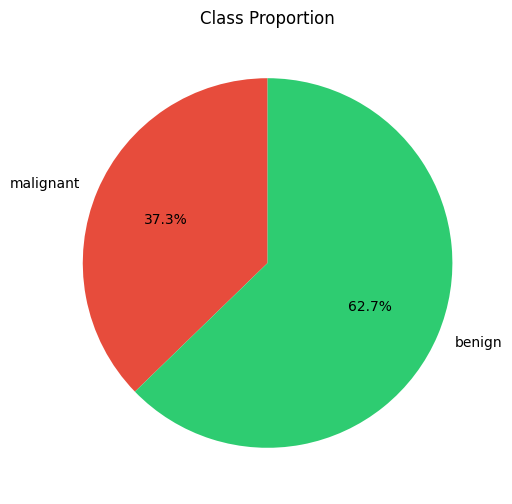

Imbalance ratio: 1.68:1


In [362]:
counts = np.unique(y, return_counts=True)[1]
colors = ["#e74c3c", "#2ecc71"]

plt.figure(figsize=(6, 6))
plt.pie(counts, labels=target_names, autopct="%1.1f%%", colors=colors, startangle=90)
plt.title("Class Proportion")
plt.show()

print(f"Imbalance ratio: {counts.max() / counts.min():.2f}:1")

#### Correlation Heatmap

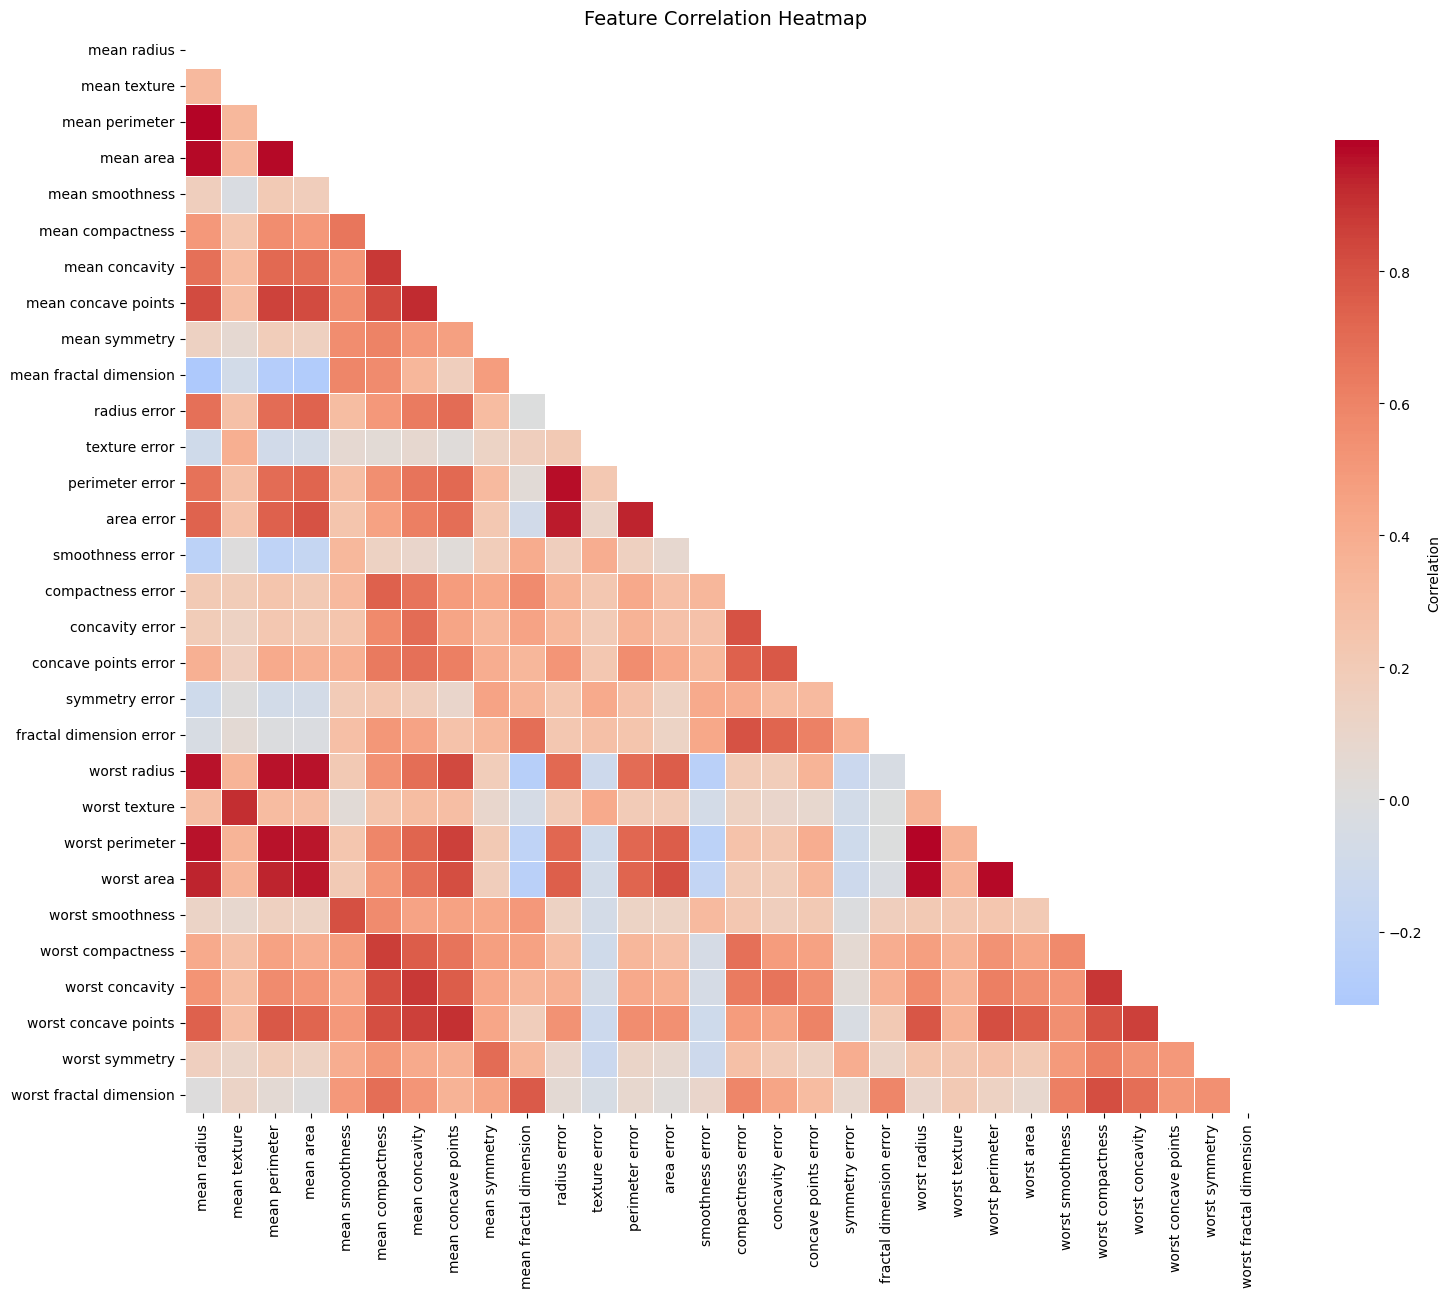

Feature pairs with |correlation| > 0.9:
  mean radius <-> mean perimeter: 0.998
  worst radius <-> worst perimeter: 0.994
  mean radius <-> mean area: 0.987
  mean perimeter <-> mean area: 0.987
  worst radius <-> worst area: 0.984
  worst perimeter <-> worst area: 0.978
  radius error <-> perimeter error: 0.973
  mean perimeter <-> worst perimeter: 0.970
  mean radius <-> worst radius: 0.970
  mean perimeter <-> worst radius: 0.969
  mean radius <-> worst perimeter: 0.965
  mean area <-> worst radius: 0.963
  mean area <-> worst area: 0.959
  mean area <-> worst perimeter: 0.959
  radius error <-> area error: 0.952
  mean perimeter <-> worst area: 0.942
  mean radius <-> worst area: 0.941
  perimeter error <-> area error: 0.938
  mean concavity <-> mean concave points: 0.921
  mean texture <-> worst texture: 0.912
  mean concave points <-> worst concave points: 0.910


In [363]:
df = pd.DataFrame(X, columns=feature_names)
df["target"] = y

corr_matrix = df.drop(columns="target").corr()

plt.figure(figsize=(16, 13))
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))  # hide upper triangle (redundant)
sns.heatmap(
    corr_matrix,
    mask=mask,
    cmap="coolwarm",
    center=0,
    annot=False,
    square=True,
    linewidths=0.5,
    cbar_kws={"shrink": 0.8, "label": "Correlation"},
)
plt.title("Feature Correlation Heatmap", fontsize=14)
plt.tight_layout()
plt.show()

# Show the most correlated pairs
high_corr = []
for i in range(len(corr_matrix.columns)):
    for j in range(i + 1, len(corr_matrix.columns)):
        if abs(corr_matrix.iloc[i, j]) > 0.9:
            high_corr.append(
                (corr_matrix.columns[i], corr_matrix.columns[j], corr_matrix.iloc[i, j])
            )

print("Feature pairs with |correlation| > 0.9:")
for f1, f2, corr in sorted(high_corr, key=lambda x: abs(x[2]), reverse=True):
    print(f"  {f1} <-> {f2}: {corr:.3f}")

#### PCA and t-SNE

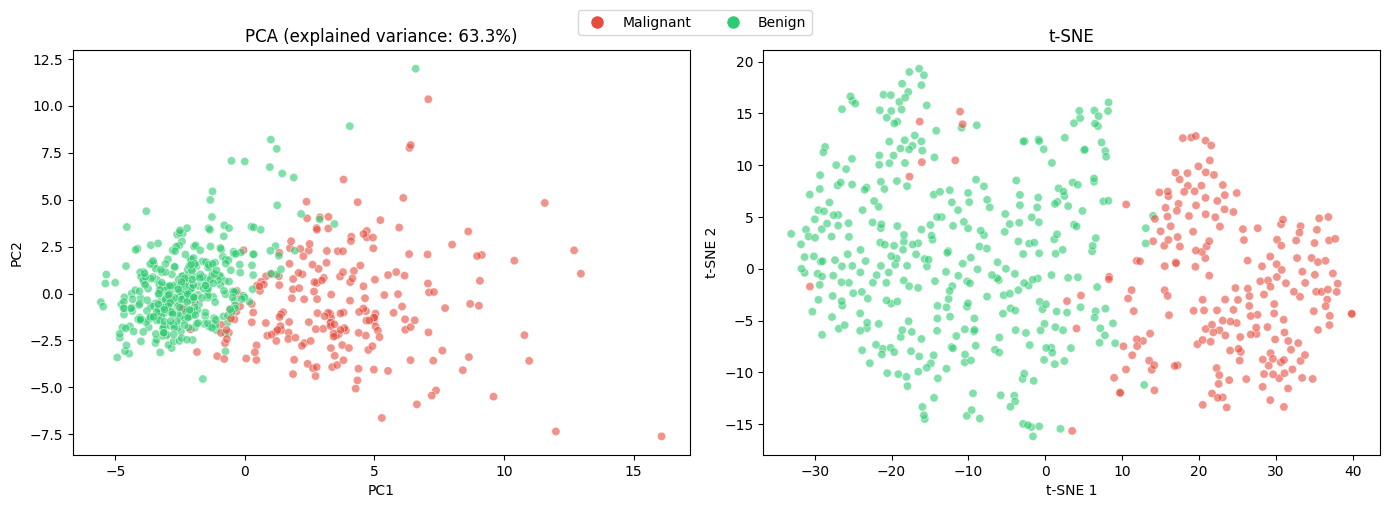

In [364]:
# Use the scaled training data for these projections
X_scaled = scaler.transform(X)  # scale the full dataset for visualization

fig, axes = plt.subplots(1, 2, figsize=(14, 5))
colors = ["#e74c3c" if label == 0 else "#2ecc71" for label in y]

# PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

axes[0].scatter(
    X_pca[:, 0], X_pca[:, 1], c=colors, alpha=0.6, edgecolors="w", linewidth=0.5
)
axes[0].set_title(
    f"PCA (explained variance: {pca.explained_variance_ratio_.sum():.1%})"
)
axes[0].set_xlabel("PC1")
axes[0].set_ylabel("PC2")

# t-SNE
tsne = TSNE(n_components=2, random_state=42, perplexity=30)
X_tsne = tsne.fit_transform(X_scaled)

scatter = axes[1].scatter(
    X_tsne[:, 0], X_tsne[:, 1], c=colors, alpha=0.6, edgecolors="w", linewidth=0.5
)
axes[1].set_title("t-SNE")
axes[1].set_xlabel("t-SNE 1")
axes[1].set_ylabel("t-SNE 2")

# Shared legend
legend_elements = [
    Line2D(
        [0],
        [0],
        marker="o",
        color="w",
        markerfacecolor="#e74c3c",
        markersize=10,
        label="Malignant",
    ),
    Line2D(
        [0],
        [0],
        marker="o",
        color="w",
        markerfacecolor="#2ecc71",
        markersize=10,
        label="Benign",
    ),
]
fig.legend(
    handles=legend_elements, loc="upper center", ncol=2, bbox_to_anchor=(0.5, 1.02)
)

plt.tight_layout()
plt.show()

#### Feature Distribution

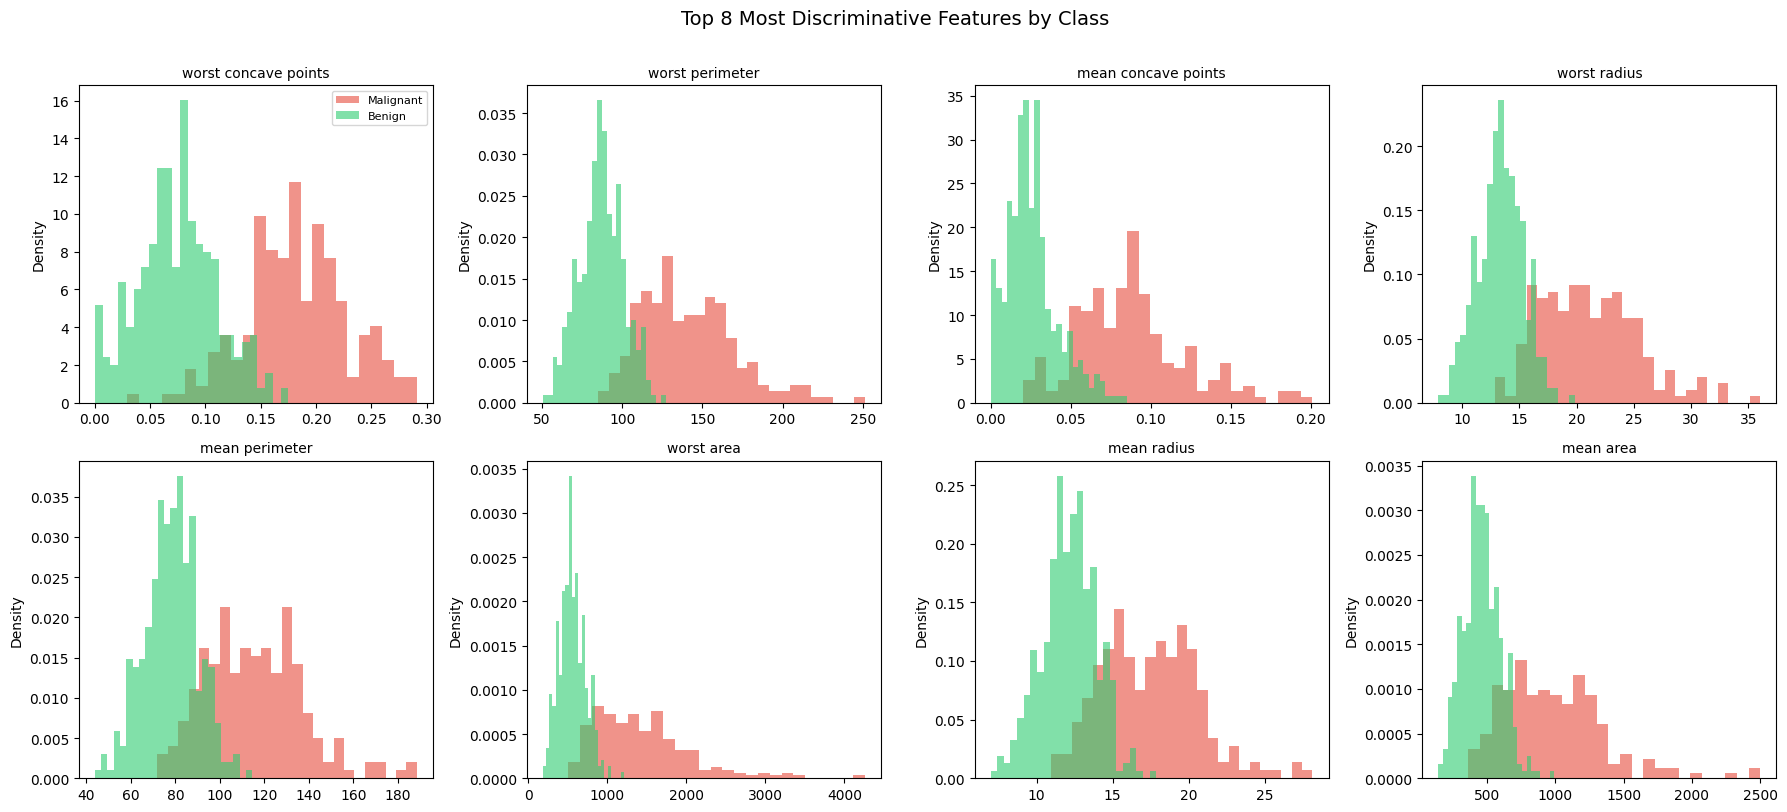

Feature ranking by standardized mean difference:
  1. worst concave points: 1.640
  2. worst perimeter: 1.618
  3. mean concave points: 1.605
  4. worst radius: 1.605
  5. mean perimeter: 1.535
  6. worst area: 1.516
  7. mean radius: 1.509
  8. mean area: 1.465
  9. mean concavity: 1.439
  10. worst concavity: 1.363


In [365]:
# Rank features by how much their means differ between classes (simple but effective)
malignant_means = df[df["target"] == 0].drop(columns="target").mean()
benign_means = df[df["target"] == 1].drop(columns="target").mean()

# Use absolute standardized difference
pooled_std = df.drop(columns="target").std()
mean_diff = ((malignant_means - benign_means).abs() / pooled_std).sort_values(
    ascending=False
)
top_features = mean_diff.head(8).index.tolist()

fig, axes = plt.subplots(2, 4, figsize=(18, 8))
axes = axes.flatten()

for i, feature in enumerate(top_features):
    axes[i].hist(
        df[df["target"] == 0][feature],
        bins=25,
        alpha=0.6,
        color="#e74c3c",
        label="Malignant",
        density=True,
    )
    axes[i].hist(
        df[df["target"] == 1][feature],
        bins=25,
        alpha=0.6,
        color="#2ecc71",
        label="Benign",
        density=True,
    )
    axes[i].set_title(feature, fontsize=10)
    axes[i].set_ylabel("Density")
    if i == 0:
        axes[i].legend(fontsize=8)

plt.suptitle("Top 8 Most Discriminative Features by Class", fontsize=14, y=1.01)
plt.tight_layout()
plt.show()

print("Feature ranking by standardized mean difference:")
for i, (feat, diff) in enumerate(mean_diff.head(10).items()):
    print(f"  {i + 1}. {feat}: {diff:.3f}")

### Data Insights & Feature Analysis Summary

- **Class Imbalance:**  
  The dataset presents a moderate class imbalance (malignant:benign ratio of 1.68:1).

- **Dimensionality Reduction:**  
  - **PCA:** The top two principal components capture 63.3% of the total variance, illustrating that much of the data's structure is represented in just two dimensions. Good class separation is already visible at this step, providing a rationale for strong performance from even simple neural networks.
  - **t-SNE:** Visualization via t-SNE reveals discernible clusters for each class, yet some overlap remains. These regions of overlap tend to correspond with instances where classification errors occur.

- **Feature Correlation & Redundancy:**  
  There is significant feature redundancy—specifically, radius, perimeter, and area are tightly correlated (correlation coefficient > 0.95) due to their mathematical relationships.

- **Most Discriminative Feature:**  
  The "worst concave points" attribute stands out as the strongest discriminator between classes. This feature captures tumor boundary irregularities, which aligns with clinical observations that such irregularities are indicative of malignancy.

## Model

In [366]:
class BCNet(nn.Module):
    def __init__(self, input_dim):
        super(BCNet, self).__init__()
        self.fc1 = nn.Linear(input_dim, 16)
        self.bn1 = nn.BatchNorm1d(16)
        self.fc2 = nn.Linear(16, 8)
        self.bn2 = nn.BatchNorm1d(8)
        self.fc3 = nn.Linear(8, 1)
        self.dropout = nn.Dropout(0.3)
        
    def forward(self, x):
        x = self.dropout(F.leaky_relu(self.bn1(self.fc1(x))))
        x = self.dropout(F.leaky_relu(self.bn2(self.fc2(x))))
        x = self.fc3(x)
        return x

### Training

In [367]:
k_folds = 5
epochs = 100
patience = 10

kfold = KFold(n_splits=k_folds, shuffle=True, random_state=42)

fold_results = []

for fold, (train_idx, val_idx) in enumerate(kfold.split(X_train_tensor)):
    print(f"\n{'=' * 40}")
    print(f"FOLD {fold + 1}/{k_folds}")
    print(f"{'=' * 40}")

    # Split data for this fold
    X_fold_train = X_train_tensor[train_idx]
    y_fold_train = y_train_tensor[train_idx]
    X_fold_val = X_train_tensor[val_idx]
    y_fold_val = y_train_tensor[val_idx]

    fold_loader = DataLoader(
        TensorDataset(X_fold_train, y_fold_train), batch_size=32, shuffle=True
    )
    
    # Compute class weights from training data
    n_malignant = (y_train == 0).sum()
    n_benign = (y_train == 1).sum()
    pos_weight = torch.tensor([n_malignant / n_benign])  # weight for the positive (benign=1) class

    print(f"Malignant: {n_malignant}, Benign: {n_benign}")
    print(f"pos_weight: {pos_weight.item():.3f}")

    criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)

    # Fresh model for each fold
    model = BCNet(input_dim=n_components)
    # criterion = nn.BCEWithLogitsLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode="min", factor=0.5, patience=5
    )

    best_val_loss = float("inf")
    patience_counter = 0
    best_model_state = None
    train_losses = []
    val_losses = []

    for epoch in range(epochs):
        # Training
        model.train()
        running_loss = 0.0
        for x_batch, y_batch in fold_loader:
            optimizer.zero_grad()
            loss = criterion(model(x_batch), y_batch)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        epoch_loss = running_loss / len(fold_loader)
        train_losses.append(epoch_loss)

        # Validation
        model.eval()
        with torch.no_grad():
            val_loss = criterion(model(X_fold_val), y_fold_val).item()
        val_losses.append(val_loss)

        scheduler.step(val_loss)

        # Early stopping
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
            best_model_state = model.state_dict().copy()
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print(f"  Early stopping at epoch {epoch + 1}")
                break

    # Restore best model and evaluate on fold validation set
    model.load_state_dict(best_model_state)
    model.eval()
    with torch.no_grad():
        val_preds = torch.sigmoid(model(X_fold_val))
        val_acc = ((val_preds >= 0.5) == y_fold_val).float().mean().item()

    fold_results.append(
        {
            "fold": fold + 1,
            "val_acc": val_acc,
            "val_loss": best_val_loss,
            "train_losses": train_losses,
            "val_losses": val_losses,
            "epochs_trained": len(train_losses),
        }
    )

    print(
        f"  Best Val Loss: {best_val_loss:.4f} | Val Accuracy: {val_acc:.4f} | Epochs: {len(train_losses)}"
    )

# Summary
print(f"\n{'=' * 40}")
print("K-FOLD SUMMARY")
print(f"{'=' * 40}")
accs = [r["val_acc"] for r in fold_results]
print(f"Fold Accuracies: {[f'{a:.4f}' for a in accs]}")
print(
    f"Mean Accuracy:   {sum(accs) / len(accs):.4f} ± {torch.tensor(accs).std().item():.4f}"
)


FOLD 1/5
Malignant: 169, Benign: 286
pos_weight: 0.591
  Early stopping at epoch 79
  Best Val Loss: 0.1198 | Val Accuracy: 0.9560 | Epochs: 79

FOLD 2/5
Malignant: 169, Benign: 286
pos_weight: 0.591
  Best Val Loss: 0.0580 | Val Accuracy: 0.9890 | Epochs: 100

FOLD 3/5
Malignant: 169, Benign: 286
pos_weight: 0.591
  Early stopping at epoch 99
  Best Val Loss: 0.0329 | Val Accuracy: 1.0000 | Epochs: 99

FOLD 4/5
Malignant: 169, Benign: 286
pos_weight: 0.591
  Early stopping at epoch 90
  Best Val Loss: 0.0989 | Val Accuracy: 0.9670 | Epochs: 90

FOLD 5/5
Malignant: 169, Benign: 286
pos_weight: 0.591
  Best Val Loss: 0.0516 | Val Accuracy: 0.9890 | Epochs: 100

K-FOLD SUMMARY
Fold Accuracies: ['0.9560', '0.9890', '1.0000', '0.9670', '0.9890']
Mean Accuracy:   0.9802 ± 0.0181


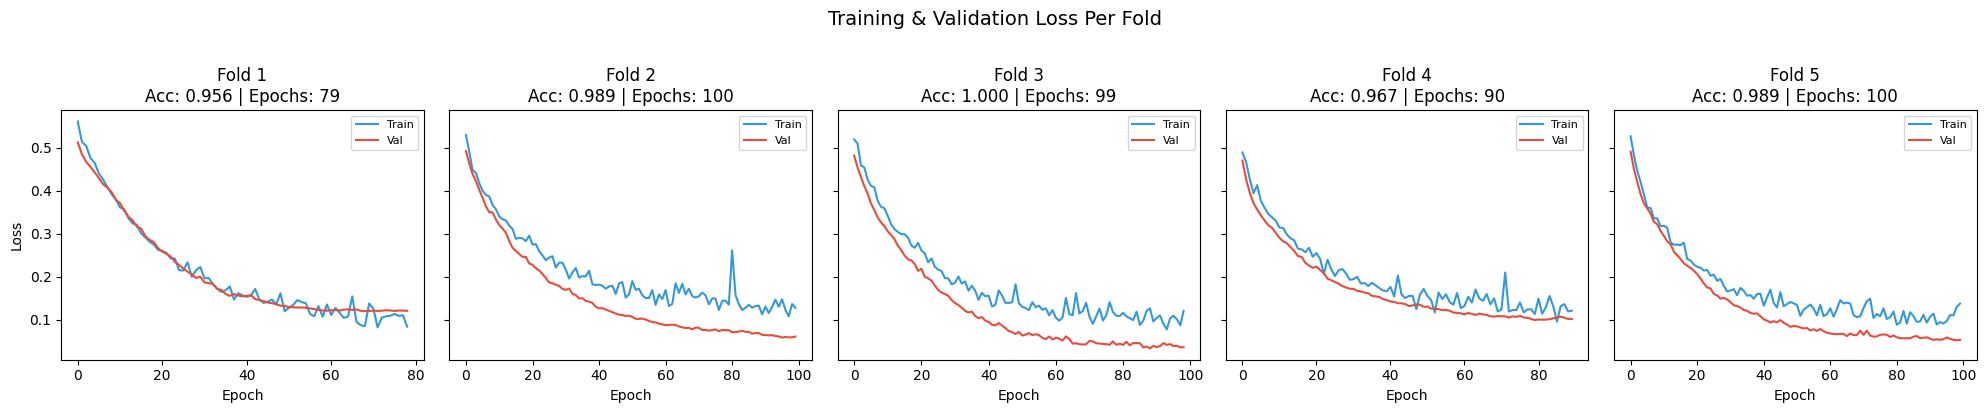

In [368]:
fig, axes = plt.subplots(1, k_folds, figsize=(4 * k_folds, 4), sharey=True)

for i, result in enumerate(fold_results):
    axes[i].plot(result["train_losses"], label="Train", color="#3498db")
    axes[i].plot(result["val_losses"], label="Val", color="#e74c3c")
    axes[i].set_title(
        f"Fold {result['fold']}\nAcc: {result['val_acc']:.3f} | Epochs: {result['epochs_trained']}"
    )
    axes[i].set_xlabel("Epoch")
    if i == 0:
        axes[i].set_ylabel("Loss")
    axes[i].legend(fontsize=8)

plt.suptitle("Training & Validation Loss Per Fold", fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

In [369]:
# Retrain on full training data with best hyperparameters
final_loader = DataLoader(
    TensorDataset(X_train_tensor, y_train_tensor), batch_size=32, shuffle=True
)

final_model = BCNet(input_dim=n_components)
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(final_model.parameters(), lr=0.001)

# Use the average epochs from K-Fold as a guide
avg_epochs = int(sum(r["epochs_trained"] for r in fold_results) / len(fold_results))
print(f"Training final model for {avg_epochs} epochs (avg from K-Fold)\n")

for epoch in range(avg_epochs):
    final_model.train()
    running_loss = 0.0
    for x_batch, y_batch in final_loader:
        optimizer.zero_grad()
        loss = criterion(final_model(x_batch), y_batch)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    if (epoch + 1) % 10 == 0:
        print(
            f"Epoch {epoch + 1}/{avg_epochs}, Loss: {running_loss / len(final_loader):.4f}"
        )

Training final model for 93 epochs (avg from K-Fold)

Epoch 10/93, Loss: 0.3994
Epoch 20/93, Loss: 0.2533
Epoch 30/93, Loss: 0.2007
Epoch 40/93, Loss: 0.1759
Epoch 50/93, Loss: 0.1394
Epoch 60/93, Loss: 0.1178
Epoch 70/93, Loss: 0.1214
Epoch 80/93, Loss: 0.1762
Epoch 90/93, Loss: 0.1324


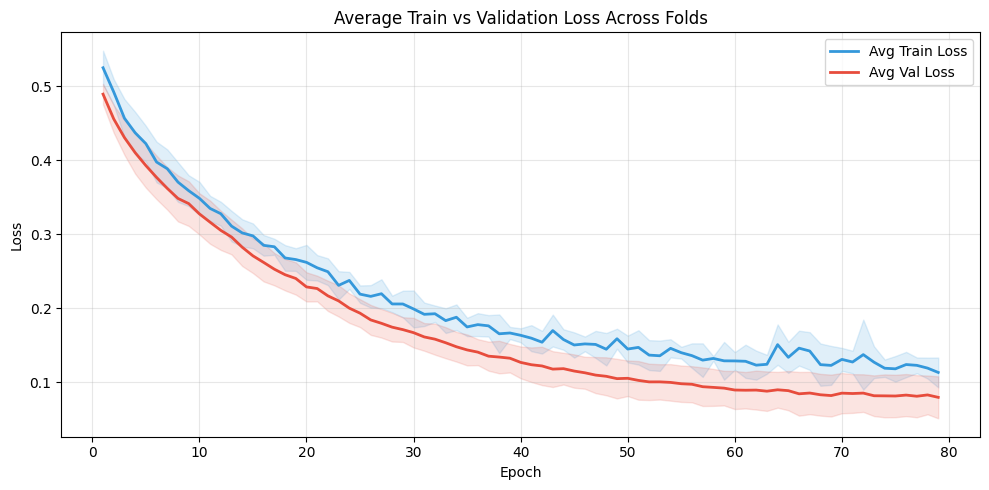

Epochs shown: 79 (shortest fold before early stopping)
Final avg train loss: 0.1132 ± 0.0202
Final avg val loss:   0.0796 ± 0.0284


In [370]:
# Find the minimum number of epochs across folds (since early stopping means different lengths)
min_epochs = min(r["epochs_trained"] for r in fold_results)

# Average losses up to the shortest fold
avg_train = np.mean([r["train_losses"][:min_epochs] for r in fold_results], axis=0)
avg_val = np.mean([r["val_losses"][:min_epochs] for r in fold_results], axis=0)

# Also get std for confidence bands
std_train = np.std([r["train_losses"][:min_epochs] for r in fold_results], axis=0)
std_val = np.std([r["val_losses"][:min_epochs] for r in fold_results], axis=0)

epochs_range = range(1, min_epochs + 1)

plt.figure(figsize=(10, 5))
plt.plot(epochs_range, avg_train, label="Avg Train Loss", color="#3498db", linewidth=2)
plt.plot(epochs_range, avg_val, label="Avg Val Loss", color="#e74c3c", linewidth=2)

# Confidence bands (±1 std)
plt.fill_between(
    epochs_range,
    avg_train - std_train,
    avg_train + std_train,
    color="#3498db",
    alpha=0.15,
)
plt.fill_between(
    epochs_range, avg_val - std_val, avg_val + std_val, color="#e74c3c", alpha=0.15
)

plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Average Train vs Validation Loss Across Folds")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(f"Epochs shown: {min_epochs} (shortest fold before early stopping)")
print(f"Final avg train loss: {avg_train[-1]:.4f} ± {std_train[-1]:.4f}")
print(f"Final avg val loss:   {avg_val[-1]:.4f} ± {std_val[-1]:.4f}")

### Evaluation

In [371]:
final_model.eval()
with torch.no_grad():
    test_logits = final_model(X_test_tensor)
    test_probs = torch.sigmoid(test_logits).numpy()
    test_preds = (test_probs >= 0.5).astype(int)

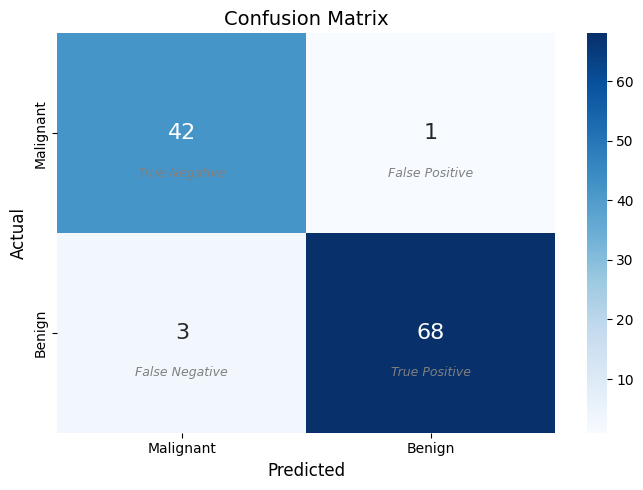

In [372]:
cm = confusion_matrix(y_test, test_preds)

plt.figure(figsize=(7, 5))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=["Malignant", "Benign"],
    yticklabels=["Malignant", "Benign"],
    annot_kws={"size": 16},
)
plt.xlabel("Predicted", fontsize=12)
plt.ylabel("Actual", fontsize=12)
plt.title("Confusion Matrix", fontsize=14)

labels = [["True Negative", "False Positive"], ["False Negative", "True Positive"]]
for i in range(2):
    for j in range(2):
        plt.text(
            j + 0.5,
            i + 0.7,
            labels[i][j],
            ha="center",
            va="center",
            fontsize=9,
            color="gray",
            style="italic",
        )

plt.tight_layout()
plt.show()

Misclassified samples: 4

  Sample 8: Actual=benign, Predicted=['malignant'], P(benign)=0.3969, Confidence=0.6031
  Sample 20: Actual=malignant, Predicted=['benign'], P(benign)=0.8531, Confidence=0.8531
  Sample 52: Actual=benign, Predicted=['malignant'], P(benign)=0.2052, Confidence=0.7948
  Sample 91: Actual=benign, Predicted=['malignant'], P(benign)=0.1630, Confidence=0.8370


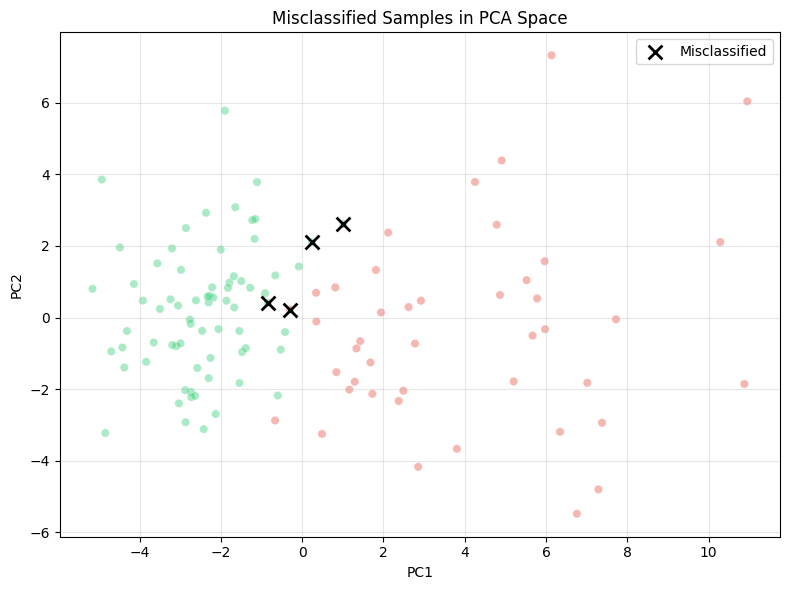

In [373]:
misclassified_idx = np.where(test_preds.flatten() != y_test.flatten())[0]

print(f"Misclassified samples: {len(misclassified_idx)}\n")
for idx in misclassified_idx:
    actual = target_names[y_test[idx]]
    predicted = target_names[test_preds[idx]]
    # test_probs[idx] may be a 1D array or float depending on torch model output, ensure it's scalar
    prob_scalar = test_probs[idx].item() if hasattr(test_probs[idx], "item") else float(test_probs[idx])
    confidence = prob_scalar if test_preds[idx] == 1 else 1 - prob_scalar
    print(f"  Sample {idx}: Actual={actual}, Predicted={predicted}, "
          f"P(benign)={prob_scalar:.4f}, Confidence={confidence:.4f}")

# Visualize where misclassified samples fall in PCA space
# If X_test_raw is not defined, but X_test exists, try to use X_test itself (before tensor transformation)
try:
    X_test_plot = X_test_raw
except NameError:
    X_test_plot = X_test if 'X_test' in locals() else None
    if X_test_plot is None:
        raise NameError("Define X_test_raw or X_test for PCA plot.")

X_test_pca = PCA(n_components=2).fit_transform(scaler.transform(X_test_plot))

plt.figure(figsize=(8, 6))
colors = ['#e74c3c' if label == 0 else '#2ecc71' for label in y_test]
plt.scatter(X_test_pca[:, 0], X_test_pca[:, 1], c=colors, alpha=0.4, edgecolors='w', linewidth=0.5)
plt.scatter(X_test_pca[misclassified_idx, 0], X_test_pca[misclassified_idx, 1],
            c='black', marker='x', s=100, linewidths=2, label='Misclassified', zorder=5)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('Misclassified Samples in PCA Space')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

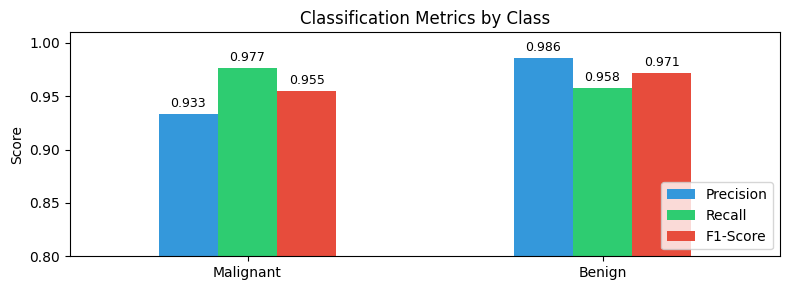

In [374]:
# Remove the unsupported 'target_names' argument
precision, recall, f1, support = precision_recall_fscore_support(y_test, test_preds)

# Generate index dynamically based on present classes in y_test and test_preds
# We know from the heatmap above that 0=Malignant, 1=Benign
class_labels = ["Malignant", "Benign"]
unique_labels = sorted(list(set(y_test) | set(test_preds.flatten())))
# Defensive: If only some classes present, index length will still match metrics
index_labels = [class_labels[i] for i in unique_labels]

metrics_df = pd.DataFrame(
    {"Precision": precision, "Recall": recall, "F1-Score": f1}, index=index_labels
)

fig, ax = plt.subplots(figsize=(8, 3))
metrics_df.plot(kind="bar", ax=ax, color=["#3498db", "#2ecc71", "#e74c3c"], rot=0)
ax.set_ylim(0.8, 1.01)
ax.set_title("Classification Metrics by Class")
ax.set_ylabel("Score")
ax.legend(loc="lower right")

# Updated: match containers to bars for compatibility
for container in ax.containers:
    ax.bar_label(container, fmt="%.3f", padding=3, fontsize=9)

plt.tight_layout()
plt.show()

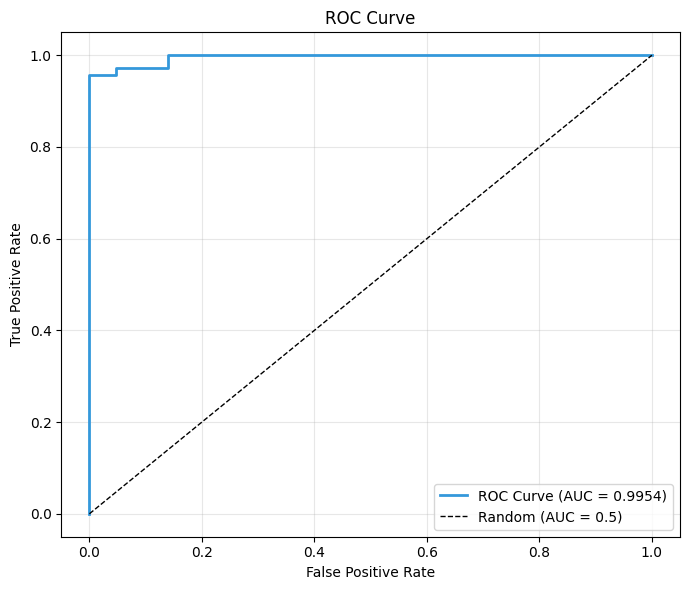

AUC: 0.9954


In [375]:
fpr, tpr, thresholds = roc_curve(y_test, test_probs)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(7, 6))
plt.plot(
    fpr, tpr, color="#3498db", linewidth=2, label=f"ROC Curve (AUC = {roc_auc:.4f})"
)
plt.plot([0, 1], [0, 1], "k--", linewidth=1, label="Random (AUC = 0.5)")

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend(loc="lower right")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(f"AUC: {roc_auc:.4f}")

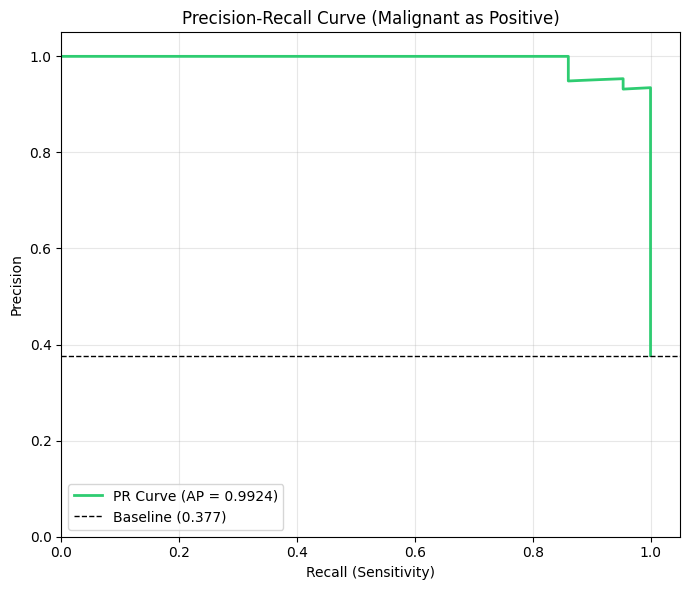

Average Precision: 0.9924


In [376]:
# Note: for PR curve in the medical context, we want malignant (0) as the positive class
# Since the dataset encodes malignant=0, we invert: use (1 - test_probs) and (1 - y_test)
precision_vals, recall_vals, pr_thresholds = precision_recall_curve(
    1 - y_test, 1 - test_probs
)
avg_precision = average_precision_score(1 - y_test, 1 - test_probs)

plt.figure(figsize=(7, 6))
plt.plot(
    recall_vals,
    precision_vals,
    color="#2ecc71",
    linewidth=2,
    label=f"PR Curve (AP = {avg_precision:.4f})",
)

# Baseline: proportion of positive class
baseline = (y_test == 0).sum() / len(y_test)
plt.axhline(
    y=baseline,
    color="k",
    linestyle="--",
    linewidth=1,
    label=f"Baseline ({baseline:.3f})",
)

plt.xlabel("Recall (Sensitivity)")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve (Malignant as Positive)")
plt.legend(loc="lower left")
plt.grid(True, alpha=0.3)
plt.xlim([0, 1.05])
plt.ylim([0, 1.05])
plt.tight_layout()
plt.show()

print(f"Average Precision: {avg_precision:.4f}")